File Download

In [17]:
!wget https://raw.githubusercontent.com/Suppersine/Thesis2021/main/taxiuber/taxiday.csv

--2021-12-26 09:13:43--  https://raw.githubusercontent.com/Suppersine/Thesis2021/main/taxiuber/taxiday.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3294 (3.2K) [text/plain]
Saving to: ‘taxiday.csv.2’

taxiday.csv.2       100%[===================>]   3.22K  --.-KB/s    in 0s      

2021-12-26 09:13:43 (28.7 MB/s) - ‘taxiday.csv.2’ saved [3294/3294]



Library

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math
%matplotlib inline

Data Plot

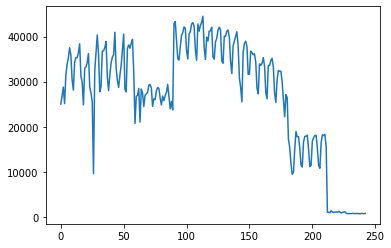

In [19]:
training_set = pd.read_csv('taxiday.csv')
#training_set = pd.read_csv('shampoo.csv')

training_set = training_set.iloc[:,1:2].values

#plt.plot(training_set, label = 'Shampoo Sales Data')
plt.plot(training_set, label = 'Taxi Daily Ridership Data (104/01-08)')
plt.show()

In [20]:
training_set.shape

(243, 1)

Dataloading

In [21]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

Model

In [22]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

Training

In [23]:
num_epochs = 200
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 10 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.87576
Epoch: 10, loss: 0.47403
Epoch: 20, loss: 0.15193
Epoch: 30, loss: 0.01766
Epoch: 40, loss: 0.02981
Epoch: 50, loss: 0.01692
Epoch: 60, loss: 0.01677
Epoch: 70, loss: 0.01638
Epoch: 80, loss: 0.01582
Epoch: 90, loss: 0.01581
Epoch: 100, loss: 0.01565
Epoch: 110, loss: 0.01558
Epoch: 120, loss: 0.01548
Epoch: 130, loss: 0.01539
Epoch: 140, loss: 0.01529
Epoch: 150, loss: 0.01519
Epoch: 160, loss: 0.01508
Epoch: 170, loss: 0.01497
Epoch: 180, loss: 0.01486
Epoch: 190, loss: 0.01474


Testing Data

238
238
data-mse = 123853350.0
data-rmse = 11128.942
data-mae = 8171.9087


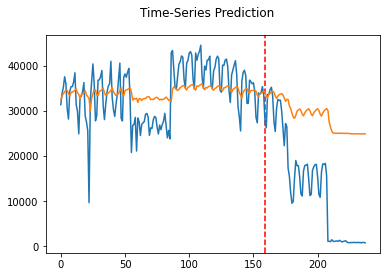

In [24]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

print(data_predict.size)
print(dataY_plot.size)
data_mse = mean_squared_error(data_predict, dataY_plot, squared=True)
data_rmse = mean_squared_error(data_predict, dataY_plot, squared=False)
data_mae = mean_absolute_error(data_predict, dataY_plot)

print("data-mse =", data_mse)
print("data-rmse =", data_rmse)
print("data-mae =", data_mae)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()